# Exploring the Natality Dataset 

**Learning Objectives**

- Explore a BigQuery dataset inside Jupyter notebook
- Read data from BigQuery into Pandas dataframe
- Examine the distribution of average baby weight across various features

## Introduction

In this notebook we'll read data from BigQuery into our notebook to begin some preliminary data exploration of the natality dataset. To beign we'll set environment variables related to our GCP project. 

In [1]:
PROJECT = "cloud-training-demos"  # Replace with your PROJECT
BUCKET = "cloud-training-bucket"  # Replace with your BUCKET
REGION = "us-central1"            # Choose an available region for Cloud MLE
TFVERSION = "1.13"                # TF version for CMLE to use

In [2]:
import os
os.environ["BUCKET"] = BUCKET
os.environ["PROJECT"] = PROJECT
os.environ["REGION"] = REGION
os.environ["TFVERSION"] = TFVERSION

In [3]:
%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
    gsutil mb -l ${REGION} gs://${BUCKET}
fi

<h2> Explore data </h2>

The data is natality data (record of births in the US). My goal is to predict the baby's weight given a number of factors about the pregnancy and the baby's mother.  Later, we will want to split the data into training and eval datasets. The hash of the year-month will be used for that -- this way, twins born on the same day won't end up in different cuts of the data.

In [4]:
# Create SQL query using natality data after the year 2000
query_string = """
SELECT
    weight_pounds,
    is_male,
    mother_age,
    plurality,
    gestation_weeks,
    ABS(FARM_FINGERPRINT(CONCAT(CAST(YEAR AS STRING), CAST(month AS STRING)))) AS hashmonth
FROM
    publicdata.samples.natality
WHERE
    year > 2000
"""

In [5]:
# Call BigQuery and examine in dataframe
from google.cloud import bigquery
bq = bigquery.Client(project = PROJECT)

df = bq.query(query_string + "LIMIT 100").to_dataframe()
df.head()

,weight_pounds,is_male,mother_age,plurality,gestation_weeks,hashmonth
0,7.936641,False,30,1,38,6691862025345277042
1,8.624484,True,34,1,39,7170969733900686954
2,6.937947,True,23,1,39,7170969733900686954
3,6.935743,True,18,1,39,1525201076796226340
4,8.318041,False,23,1,40,8904940584331855459


Let's write a query to find the unique values for a given column and see how the number of babies and their average weight is distributed across a those values. This is important to ensure that we have enough examples of each data value, and to verify our hunch that the parameter has predictive value.

In [6]:
def get_distinct_values(column_name):
    sql_query = """
    SELECT
        {0},
        COUNT(1) AS num_babies,
        AVG(weight_pounds) AS avg_wt
    FROM
        publicdata.samples.natality
    WHERE
        year > 2000
    GROUP BY
        {0}
    """.format(column_name)
    return bq.query(sql_query).to_dataframe()

We'll use the `get_distinct_values` function above to explore how the variables `num_babies` and `avg_wt` are distributed across the features `is_male`, `mother_age`, `plurality` and `gestation_weeks`

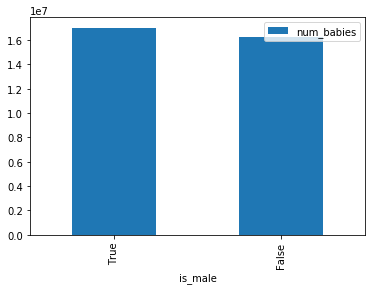

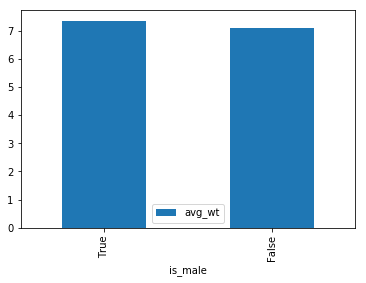

In [7]:
# Bar plot to see is_male with avg_wt linear and num_babies logarithmic
df = get_distinct_values("is_male")
df.plot(x = "is_male", y = "num_babies", kind = "bar");
df.plot(x = "is_male", y = "avg_wt", kind = "bar");

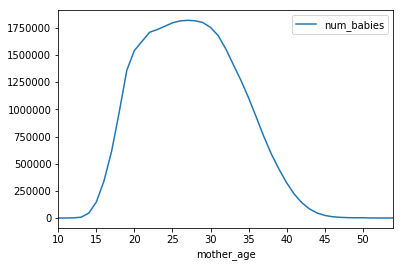

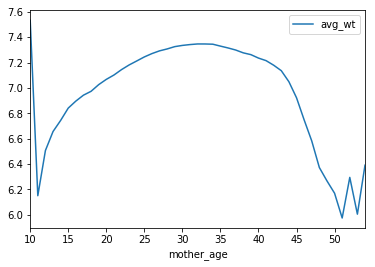

In [8]:
# Line plots to see mother_age with avg_wt linear and num_babies logarithmic
df = get_distinct_values("mother_age")
df = df.sort_values("mother_age")
df.plot(x = "mother_age", y = "num_babies");
df.plot(x = "mother_age", y = "avg_wt");

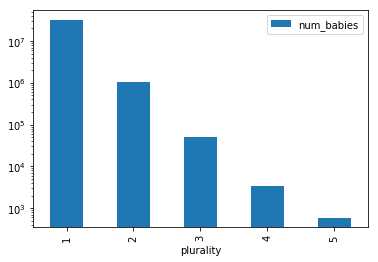

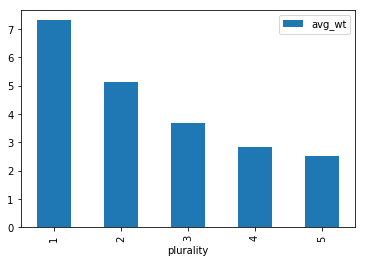

In [9]:
# Bar plot to see plurality(singleton, twins, etc.) with avg_wt linear and num_babies logarithmic
df = get_distinct_values("plurality")
df = df.sort_values("plurality")
df.plot(x = "plurality", y = "num_babies", logy = True, kind = "bar");
df.plot(x = "plurality", y = "avg_wt", kind = "bar");

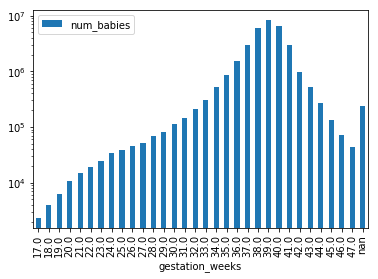

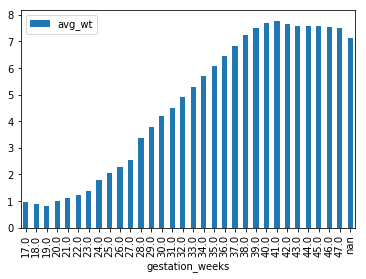

In [10]:
# Bar plot to see gestation_weeks with avg_wt linear and num_babies logarithmic
df = get_distinct_values("gestation_weeks")
df = df.sort_values("gestation_weeks")
df.plot(x = "gestation_weeks", y = "num_babies", logy = True, kind = "bar");
df.plot(x = "gestation_weeks", y = "avg_wt", kind = "bar");

## Conclusion 

All these factors seem to play a part in the baby's weight. Male babies are heavier on average than female babies. Teenaged and older moms tend to have lower-weight babies. Twins, triplets, etc. are lower weight than single births. Preemies weigh in lower as do babies born to single moms. In addition, it is important to check whether you have enough data (number of babies) for each input value. Otherwise, the model prediction against input values that doesn't have enough data may not be reliable.
<p>
In the next notebook, we will develop a machine learning model to combine all of these factors to come up with a prediction of a baby's weight.

Copyright 2017-2018 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License